In [ ]:
%matplotlib inline
import zipfile

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab_Notebooks/cropped.zip", 'r')
zip_ref.extractall("/content/drive/MyDrive/Colab_Notebooks/data")
zip_ref.close()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np

import torchvision
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models as models
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
# pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [ ]:
image_size = 64
batch_size = 4

In [ ]:
train_dataset = ImageFolder('/content/drive/MyDrive/Colab_Notebooks/data/train', transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor()]))

In [ ]:
test_dataset = ImageFolder('/content/drive/MyDrive/Colab_Notebooks/data/test', transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor()]))

In [ ]:
val_dataset = ImageFolder('/content/drive/MyDrive/Colab_Notebooks/data/val', transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor()]))

In [ ]:
classes = ('face', 'masked', 'sunglasses','sunglasses_masked')  #this should be arranged the way the folders are arranged in the directory

In [ ]:
trainloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valloader = DataLoader(val_dataset,batch_size,shuffle=True,num_workers=2,pin_memory=True)
testloader = DataLoader(test_dataset,batch_size,shuffle=True,num_workers=2,pin_memory=True)

Display some of the training images




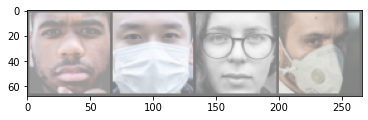

face  masked face  masked


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
#dataiter = iter(trainloader)

images, labels = next(iter(trainloader))
#print(images.size())

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# ***Define Resnet Model***

In [ ]:
class BasicBlock(nn.Module): #applies a bunch of conv blocks, adds intermediate o/p to i/p layers. also downsamples the input before adding it to o/p
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=4):
        super().__init__()

        self.inplanes = 64

        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 , num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)           # 224x224
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)         # 112x112

        x = self.layer1(x)          # 56x56
        x = self.layer2(x)          # 28x28
        x = self.layer3(x)          # 14x14
        x = self.layer4(x)          # 7x7

        x = self.avgpool(x)         # 1x1
        x = torch.flatten(x, 1)     # convert 1 X 1 to vector
        x = self.fc(x)

        return x

In [ ]:
layers=[3, 4, 6, 3]
'''
layer2 = _make_layer(BasicBlock, 64, 128, layers[1], stride=2)
layer2
layer1 =_make_layer(BasicBlock, inplanes=64,planes=64, blocks=layers[0])
layer1 '''

'\nlayer2 = _make_layer(BasicBlock, 64, 128, layers[1], stride=2)\nlayer2\nlayer1 =_make_layer(BasicBlock, inplanes=64,planes=64, blocks=layers[0])\nlayer1 '

In [ ]:
model = ResNet(BasicBlock, layers)

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch.optim as optim

num_classes = 4
num_epochs = 30

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

total_step = len(trainloader)

### 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [ ]:
import gc
train_loss = []
accuracy = []
total_step = len(trainloader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):  
        # Move tensors to the configured device

        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss.append(loss)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    print ('Epoch [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, loss.item()))
            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
        accuracy.append(100 * correct / total )
        print('Accuracy of the network on validation images: {} %'.format(100 * correct / total)) 

Epoch [1/30], Loss: 0.5142
Accuracy of the network on validation images: 45.535714285714285 %
Epoch [2/30], Loss: 1.1991
Accuracy of the network on validation images: 50.892857142857146 %
Epoch [3/30], Loss: 0.9417
Accuracy of the network on validation images: 77.67857142857143 %
Epoch [4/30], Loss: 0.2938
Accuracy of the network on validation images: 66.96428571428571 %
Epoch [5/30], Loss: 0.0617
Accuracy of the network on validation images: 77.67857142857143 %
Epoch [6/30], Loss: 0.1989
Accuracy of the network on validation images: 75.0 %
Epoch [7/30], Loss: 0.8781
Accuracy of the network on validation images: 81.25 %
Epoch [8/30], Loss: 0.0226
Accuracy of the network on validation images: 76.78571428571429 %
Epoch [9/30], Loss: 0.0220
Accuracy of the network on validation images: 75.89285714285714 %
Epoch [10/30], Loss: 0.0085
Accuracy of the network on validation images: 76.78571428571429 %
Epoch [11/30], Loss: 0.0143
Accuracy of the network on validation images: 81.25 %
Epoch [12/

Let's quickly save our trained model:



In [ ]:
PATH = '/content/drive/MyDrive/Colab_Notebooks/data/model.pth'
torch.save(model.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html)
for more details on saving PyTorch models.

### 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



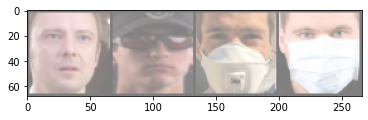

GroundTruth:  face  sunglasses masked masked


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [ ]:
model = ResNet(BasicBlock, layers)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
outputs = model(images)

In [ ]:
_, predicted = torch.max(outputs, 1)
#print(_)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  face  sunglasses masked masked


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on test images: {100 * correct // total} %')

Accuracy of the network on test images: 75 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in valloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

    #masked data also has face with spectacles, maybe that is why sunglaasses' accuracy is low - work on this

Accuracy for class: face  is 90.5 %
Accuracy for class: masked is 88.6 %
Accuracy for class: sunglasses is 74.4 %
Accuracy for class: sunglasses_masked is 76.5 %


In [ ]:
'''target = torch.tensor(total_pred.values())
preds = torch.Tensor(correct_pred.values())

from torchmetrics.classification import MulticlassConfusionMatrix
metric = MulticlassConfusionMatrix(num_classes=4)
metric(preds, target)'''